# Определение возраста покупателей по фото

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

## Задача проекта:
Построить модель, которая по фотографии определит приблизительный возраст человека. Целевой показатель качества нейронной сети MAE = 7, максимально допустимый - 8.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Nadam

## Исследовательский анализ данных

Прочитаем предоставленные данные

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

Стандартизируем изображение по размеру и цветности, а также разделим выборку на обучающую и тестовую

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw', 
    subset='training', 
    seed=42) 

Found 5694 validated image filenames.


In [4]:
validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

val_gen_flow = validation_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=42)

Found 1897 validated image filenames.


In [5]:
features, target = next(train_gen_flow)

In [6]:
len(labels)

7591

В предоставленной выборке 7591 изображение людей - этого достаточно для того чтобы обучить модель. Но большее количество изображенй позволило бы научиться определять возраст более точно, особенно в возрастных категориях, где по естесственным причинам меньше людей (например пожилые люди).

In [7]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Построим гистограмму возрастов в выборке.

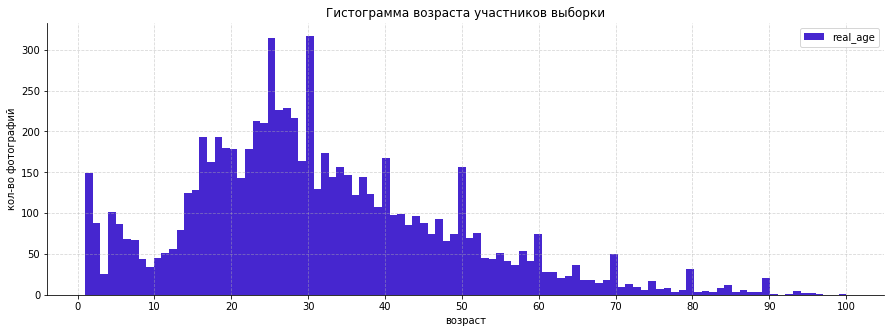

In [8]:
ax = labels.plot(kind='hist', y='real_age', facecolor='#4626CF', bins=100, figsize=(15, 5))
ax.set(xlabel='возраст', ylabel='кол-во фотографий', title='Гистограмма возраста участников выборки')
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
ax.grid(which='major', axis='y', alpha=0.5, ls='--')
ax.grid(which='major', axis='x', alpha=0.5, ls='--')
plt.xticks(np.arange(0, 101, 10))
plt.show()

Большая часть изображений содержит лица людей молодого возраста: 17-35 лет. Это может объясняться тем, что эта возрастная категория наиболее социально активна, то есть и чаще оставляет свои фото: например, публикуя в социальных сетях.

Стоит отметить, что, начиная с 25 лет есть пики по количеству фотографий на круглые даты: 30, 40, 50 и т.д. Вероятно, такие данные появились, потому что иногда люди не указывают свой точный возраст, а указывают лишь возрастную категорию. Или разметкой данных занимались сторонниелюди, которые не могли знать точный возраст указанного перед ними человека. Такое распределение может увеличить ошибку при обучении модели - так как в данном случае система будет чаще определять округленные цифры.

Очевидно, что начиная с 30 лет, количество фотографий в каждой возрастной категории становится меньше, особенно ярко это проявляется в отношении людей старше 60 лет. Малое количество фотографий людей пожилого возраста легко объясняется несколькими причинами: 1. чем выше возраст, тем меньше людей до него доживает, 2. пожилые люди не любят фотографироваться, 3. визуальная разница между человеком в 60 лет и 80 лет не такая яркая, чем между 15 и 35 (например). 

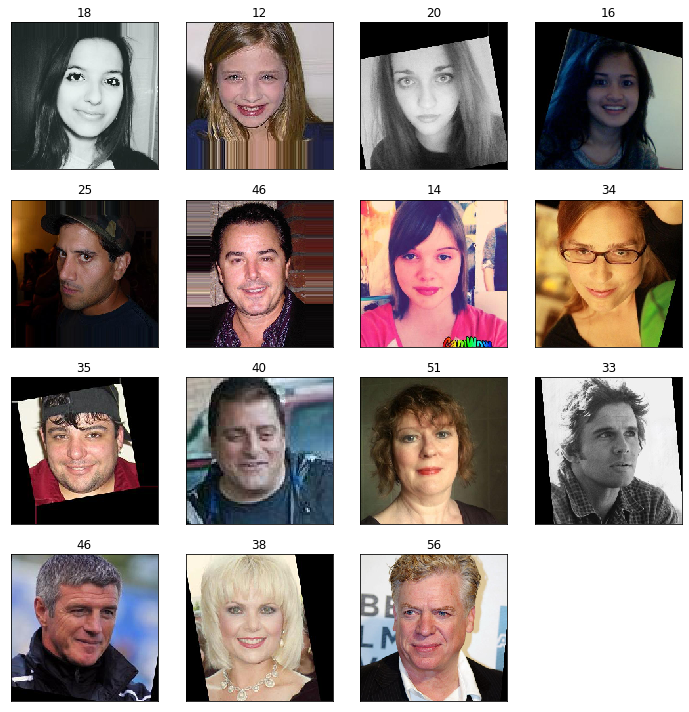

In [9]:
fig = plt.figure(figsize=(10, 10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(label=target[i])
    plt.tight_layout()

Фотографии, представленные в выборке как полноцветные, так и монохромные, но не высокого качества, любительские. По своему формату однородные: лицо и часть плечей. 
Кроме того, в фотографиях множество поворотов. Возможно они появились так как предобработка фото как-бы довернула и вырезала нужную часть (лицо и плечи) с более крупной, неформатной фотографии. 
Стоит попробовать компенсировать эти 'шумы' в изображениях отражением фото по горизонтали.

## Обучение модели

In [ ]:
def load_train(path):
 
    labels = pd.read_csv(path+'labels.csv')
 
    train_datagen = ImageDataGenerator(
                          validation_split=0.25,
                          rescale=1./255,
                          horizontal_flip=True
                          )
    
    
    
    train_datagen_flow = (train_datagen.flow_from_dataframe(
                          dataframe=labels, 
                          directory=path + 'final_files/',
                          x_col='file_name', 
                          y_col='real_age', 
                          target_size=(224, 224), 
                          batch_size=16, 
                          class_mode='raw',
                          subset='training', 
                          seed=12345
                          )
    )
    
    return train_datagen_flow

def load_test(path):
 
    labels = pd.read_csv(path + 'labels.csv')
 
    test_datagen = ImageDataGenerator(
                          validation_split=0.25,
                          rescale=1./255
                          )
 
   
    test_datagen_flow = (test_datagen.flow_from_dataframe(
                          dataframe=labels, 
                          directory=path + 'final_files/',
                          x_col='file_name', 
                          y_col='real_age', 
                          target_size=(224, 224), 
                          batch_size=16, 
                          class_mode='raw',
                          subset='validation', 
                          seed=12345
                          )
    )
    
    return test_datagen_flow

def create_model(input_shape):
 
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    optimizer=Nadam(learning_rate=0.0001)
 
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model

def train_model(model, train_data, test_data, epochs=8, batch_size=None,
               steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data, 
              validation_data=(test_data),
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps,
              verbose=2, 
              shuffle=True)
 
    return model 

'''
Train for 356 steps, validate for 119 steps
Epoch 1/8
356/356 - 60s - loss: 195.0851 - mae: 10.1870 - val_loss: 685.0407 - val_mae: 21.1663
Epoch 2/8
356/356 - 39s - loss: 78.2818 - mae: 6.7144 - val_loss: 143.1076 - val_mae: 8.9110
Epoch 3/8
356/356 - 39s - loss: 54.6553 - mae: 5.6524 - val_loss: 69.3571 - val_mae: 6.2689
Epoch 4/8
356/356 - 39s - loss: 42.0389 - mae: 4.9038 - val_loss: 73.1178 - val_mae: 6.3687
Epoch 5/8
356/356 - 40s - loss: 28.8289 - mae: 4.1222 - val_loss: 82.9098 - val_mae: 7.0450
Epoch 6/8
356/356 - 39s - loss: 22.5477 - mae: 3.6322 - val_loss: 67.8161 - val_mae: 6.1015
Epoch 7/8
356/356 - 39s - loss: 18.6506 - mae: 3.2824 - val_loss: 90.6696 - val_mae: 7.3078
Epoch 8/8
356/356 - 39s - loss: 16.5778 - mae: 3.0974 - val_loss: 68.5239 - val_mae: 6.3474
'''

## Общий вывод

В результате обучения модели удалось достигнуть MAE=6.34, что соответсвует условиям проекта. 
Однако, MAE на обучающей выборке вдвое меньше MAE на тестовой выборке (составляет 3.09). То есть сеть переобучается, вероятно, из-за склонности многослойных нейронных сетей к переобучению.